### Import Modules

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.patches as patches
import pickle
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings('ignore')

### Function for Space-Time Diagrams

In [35]:
cdict = {'red'  :  ((0., 0., 0.), (0.2, 1., 1.), (0.6, 1., 1.), (1., 0., 0.)),
         'green':  ((0., 0., 0.), (0.2, 0., 0.), (0.6, 1., 1.), (1., 1., 1.)),
         'blue' :  ((0., 0., 0.), (0.2, 0., 0.), (0.6, 0., 0.), (1., 0., 0.))}

my_cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

def space_time_diagram(pos, speed, time, title, max_speed=8):
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes()
    norm = plt.Normalize(0, max_speed) # TODO: Make this more modular
    cols = []

    for indx_car in range(pos.shape[1]):
        unique_car_pos = pos[:,indx_car]

        # discontinuity from wraparound
        disc = np.where(np.abs(np.diff(unique_car_pos)) >= 100)[0]+1
        unique_car_time = np.insert(time, disc, np.nan)
        unique_car_pos = np.insert(unique_car_pos, disc, np.nan)
        unique_car_speed = np.insert(speed[:,indx_car], disc, np.nan)

        points = np.array([unique_car_time, unique_car_pos]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=my_cmap, norm=norm)

        # Set the values used for colormapping
        lc.set_array(unique_car_speed)
        lc.set_linewidth(1.75)
        cols = np.append(cols, lc)

    xmin, xmax = min(time), max(time)
    xbuffer = (xmax - xmin) * 0.025 # 2.5% of range
    ymin, ymax = np.amin(pos), np.amax(pos)
    ybuffer = (ymax - ymin) * 0.025 # 2.5% of range

    ax.set_xlim(xmin - xbuffer, xmax + xbuffer)
    ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

    plt.title(title, fontsize=25)
    plt.ylabel('Position (m)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)

    for col in cols:
        line = ax.add_collection(col)
    cbar = plt.colorbar(line, ax=ax)
    cbar.set_label('Velocity (m/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

#     # NOTE: FOR OPEN NETWORK MERGE ONLY
#     plt.plot(np.arange(pos.shape[0])*dt, [600]*pos.shape[0], "--", linewidth=2, color="k")
    plt.plot(np.arange(pos.shape[0])*dt, [0]*pos.shape[0], linewidth=3, color="white")
    plt.plot(np.arange(pos.shape[0])*dt, [-0.1]*pos.shape[0], linewidth=3, color="white")

    plt.show()

### Function for Importing Edge / Position / Speed by Vehicle ID

In [ ]:
def import_edge_pos_speed(csv_filepath):
    """Import edge, position, and speed data from an emission csv.

    Parameters
    ----------
    csv_filepath : str
        location of the emission csv file

    Returns
    -------
    dict < dict >
        Key = vehicle id
            Key = "edge", "pos", "speed", "lane", or "time"
            Element = list of specified data for vehicle
    """
    # import the csv file into a pandas dataframe
    data = pd.read_csv(csv_filepath)

    # create an empty dict for the results
    res = dict().fromkeys(np.unique(data["id"]))

    for veh_id in res.keys():
        res[veh_id] = dict()
        indx_data = data["id"] == veh_id
        res[veh_id]["edge"] = list(data["edge_id"][indx_data])
        res[veh_id]["pos"] = list(data["relative_position"][indx_data])
        res[veh_id]["speed"] = list(data["speed"][indx_data])
        res[veh_id]["lane"] = list(data["lane_number"][indx_data])
        res[veh_id]["time"] = list(data["time"][indx_data])

    return res

# Highway with Perturbations

## Network Parameters

In [ ]:
inflow_edge_len = 100
merge = 100
premerge = 500
postmerge = 100
total_len = merge + premerge + postmerge + 2*inflow_edge_len + 8.1

edgestarts_merge = {
    "inflow_highway": 0,
    "left": inflow_edge_len + 0.1,
    "center": inflow_edge_len + premerge + 8.1,
    "inflow_merge": inflow_edge_len + premerge + postmerge + 8.1,
    "bottom": 2*inflow_edge_len + premerge + postmerge + 8.2,
    ":left_0": inflow_edge_len,
    ":center_0": inflow_edge_len + premerge + 0.1,
    ":center_1": inflow_edge_len + premerge + 0.1,
    ":bottom_0": 2*inflow_edge_len + premerge + postmerge + 8.1
}

## SImulation Parameters

In [ ]:
num_steps = 18000  # number of simulation steps
offset = 0  # number of steps offset from the beginning
dt = 0.2  # simulation step size

## Utility Functions

In [ ]:
def get_speed_pos_merge(merge_data, 
                        edgestarts, 
                        num_steps, 
                        dt):
    """Compute the absolute position, speed, average speed from
    merge data.

    The data is converted to a representation that is compatible with
    plotting methods in place (e.g. space-time diagram).
    """
    # compute the absolute position
    for veh_id in merge_data.keys():
        merge_data[veh_id]["abs_pos"] = []
        for edge, pos in zip(merge_data[veh_id]["edge"], 
                             merge_data[veh_id]["pos"]):
            merge_data[veh_id]["abs_pos"].append(pos + edgestarts[edge])

    # prepare the speed and absolute position in a way that is compatible 
    # with the space-time diagram, and compute the number of vehicles at 
    # each step
    pos = np.zeros((num_steps, len(merge_data.keys())))
    speed = np.zeros((num_steps, len(merge_data.keys())))
    num_veh = [0 for _ in range(num_steps)]
    for i, veh_id in enumerate(merge_data.keys()):
        for spd, abs_pos, ti, edge in zip(merge_data[veh_id]["speed"],
                                          merge_data[veh_id]["abs_pos"],
                                          merge_data[veh_id]["time"],
                                          merge_data[veh_id]["edge"]):
            if int(ti*(1/dt)) >= num_steps \
                        or edge in ["inflow_merge", "bottom", ":bottom_0"]:
                continue
            speed[int(ti*(1/dt)), i] = spd
            pos[int(ti*(1/dt)), i] = abs_pos
            num_veh[int(ti*(1/dt))] += 1

    # compute the average speed
    avg_speed = np.sum(speed, axis=1) / num_veh

    return pos, speed, avg_speed, num_veh

## Speed and Density Plots

In [ ]:
# baseline simulation results
avg_speed = []
num_veh = []
num_enter_baseline = []
num_exit_baseline = []
for i in range(10):
    print(i)
    baseline = import_edge_pos_speed("merge-baseline-emission-2000-{}.csv".format(i))

    # conversion to acceptable forms for plotting
    pos_baseline, speed_baseline, avg_speed_baseline, n_veh = get_speed_pos_merge(
        merge_data=baseline,
        edgestarts=edgestarts_merge, 
        num_steps=num_steps,
        dt=dt
    )
    avg_speed.append(avg_speed_baseline)
    num_veh.append(n_veh)
    num_enter_baseline.append(pos_baseline.shape[1])
    num_exit_baseline.append(sum(pos_baseline[-1,:]==0))

avg_speed_baseline = np.mean(avg_speed, axis=0)
num_veh_baseline = np.mean(num_veh, axis=0)

In [ ]:
# rl simulation results
avg_speed = []
num_veh = []
rl_speed = []
rl_num_veh = []
num_enter_rl = []
num_exit_rl = []
for frac in [0.025, 0.05, 0.1]:
    for i in range(10):
        print(frac, i)
        rl = import_edge_pos_speed("merge-rl-emission-%.3f-%d.csv" % (frac, i))

        # conversion to acceptable forms for plotting
        pos_rl, speed_rl, avg_speed_rl, n_veh = get_speed_pos_merge(
            merge_data=rl,
            edgestarts=edgestarts_merge, 
            num_steps=num_steps,
            dt=dt
        )
        avg_speed.append(avg_speed_rl)
        num_veh.append(n_veh)
        num_enter_rl.append(pos_rl.shape[1])
        num_exit_rl.append(sum(pos_rl[-1,:]==0))
    rl_speed.append(np.mean(avg_speed, axis=0))
    rl_num_veh.append(np.mean(num_veh, axis=0))

In [ ]:
int(len(avg_speed)/1)

In [ ]:
print(len(avg_speed_baseline))

[np.mean(avg_speed_baseline[i*mult:(i+1)*mult]) for i in range(int(len(avg_speed_baseline)/mult))]

In [ ]:
mult = 250

# plot the average speed
plt.figure(figsize=(14,9))
plt.title("Average Velocity of Vehicles on the Highway", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("velocity (m/s)", fontsize=20)
a = [np.mean(avg_speed_baseline[i*mult:(i+1)*mult]) for i in range(int(len(avg_speed_baseline)/mult))]
a[0] = 0
print(np.mean(a[5:]))
plt.plot(np.arange(num_steps)[::mult]*dt, a, linewidth=2)
for avg_speed in rl_speed:
    a = [np.mean(avg_speed[i*mult:(i+1)*mult]) for i in range(int(len(avg_speed)/mult))]
    a[0] = 0
    print(np.mean(a[5:]))
    plt.plot(np.arange(num_steps)[::mult]*dt, a, linewidth=2)
plt.legend(["0% AV Penetration", "2.5% AV Penetration",
            "5% AV Penetration", "10% AV Penetration"], fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# plot the number of vehicles
plt.figure(figsize=(14,9))
plt.title("Number of Vehicles on the Highway", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("number of vehicles", fontsize=20)
a = [np.mean(num_veh_baseline[i*mult:(i+1)*mult]) 
     for i in range(int(len(num_veh_baseline)/mult))]
a[0] = 0
plt.plot(np.arange(num_steps)[::mult]*dt, a, linewidth=2)
for num_veh in rl_num_veh:
    a = [np.mean(num_veh[i*mult:(i+1)*mult]) for i in range(int(len(num_veh)/mult))]
    a[0] = 0
    plt.plot(np.arange(num_steps)[::mult]*dt, a, linewidth=2)
plt.legend(["0% CAV Penetration", "2.5% CAV Penetration",
            "5% CAV Penetration", "10% CAV Penetration"], fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [75]:
import csv 
import statistics
def get_average_speed(fp):              #takes file path as input 


    with open(fp) as csvfile: 
        readCSV = csv.reader(csvfile)
        v = [] 
        for row in readCSV:
            v.append(row[3])
        v.remove('speed')  
        x = len(v)
        v = [int(float(i)) for i in v]
        x = len(v)
        v = v[int(x/2):x]
        vavg = statistics.mean(v)

    return vavg 


In [76]:
# get the names of all the directories starting with \
path = "./flow/examples/sumo/IDM,with_noise"
dirs = os.listdir( path )
files=[] 
for file in dirs:
    if file[0]=="l":
        files.append(file)
x=[]
y=[]
z=[]

for dir_i in files:
    # from the name, extract the length
    total_len = int(dir_i[2]+dir_i[3]+dir_i[4]) 

    # from the name, extract v0 
    if len(dir_i)<11:
        v0 = int(dir_i[9])
    else: 
        v0 = int(dir_i[9]+dir_i[10])

    # check for the elements in the dir_i folder and choose the file that ends with .csv
    m = glob.glob("flow/examples/sumo/IDM,with_noise/l={}-v0={}/*.csv".format(total_len,v0))
    file_path = m[0]


    # compute the desired Vel,length,and average speed of vehicles in each simulation 
    x.append(total_len)
    y.append(v0)
    z.append(get_average_speed(file_path))

In [79]:
z

[3.9254490927266668,
 4.025173427039472,
 4.041168095483323,
 3.947562933567599,
 3.963951410136015,
 3.8694677531731845,
 4.038078216352125,
 2.9719487443579413,
 4.024840204780225,
 3.946896489049105,
 4.054921086910424,
 2.9717669867619882,
 3.957953409469571,
 3.891945109206022,
 3.9471085395777163,
 3.9637393596074038,
 3.991972372845415,
 3.9243585471509497,
 4.020902123534579,
 4.012389809457454,
 4.013934749023053,
 4.017115506952228,
 3.9902759686165217,
 4.038896125533913,
 4.050104510617673,
 4.068552906606889,
 3.9997576565387294,
 3.982187755596619,
 3.9315985580564052,
 3.9332040834873223,
 3.9466541455878343,
 4.079185725970131,
 3.9783405531489504,
 3.8856441792129894,
 3.992517645633274,
 2.9720699160885764,
 3.9357486898306626,
 4.031444064099846,
 3.946684438520493,
 4.000878495047106,
 3.914876859228742,
 3.8718911877858897,
 4.035473024143467,
 3.9344460937263337,
 3.946714731453152,
 3.934234043197722,
 3.9540153282239254,
 3.9442610039077883,
 4.0703098967011,
 4

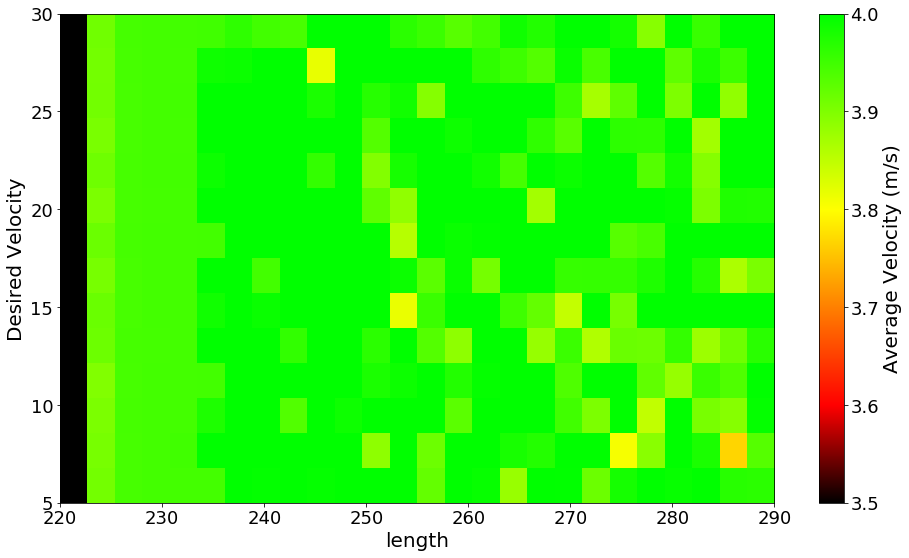

In [81]:
points = np.stack((x,y)).T
grid_x, grid_y = np.mgrid[220:290:5,5:31:1]
a = griddata(points, z, (grid_x, grid_y))
plt.figure(figsize=(16,9))
norm = plt.Normalize(3.5, 4)
# plt.title("Velocity Distribution for Vehicles in the Highway", fontsize=25)
plt.xlabel("length", fontsize=20)
plt.ylabel("Desired Velocity", fontsize=20)
plt.imshow(a, extent=(220,290,5,30), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_label('Average Velocity (m/s)', fontsize=20)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Heat Map Plots

In [37]:
# simulation results
baseline = import_edge_pos_speed("merge-baseline-emission-2000-0.csv")

pos_baseline, speed_baseline, _, _ = get_speed_pos_merge(
    merge_data=baseline,
    edgestarts=edgestarts_merge, 
    num_steps=num_steps,
    dt=dt)

pos = pos_baseline[::15]
speed = speed_baseline[::15]
x = pos.flatten()
t = np.array([np.repeat(i * 15 * dt, pos.shape[1]) for i in range(pos.shape[0])]).flatten()
values = speed.flatten()

t = np.delete(t, np.where(x == 0)[0])
values = np.delete(values, np.where(x == 0)[0])
x = np.delete(x, np.where(x == 0)[0])

points = np.stack((x,t)).T
grid_x, grid_y = np.mgrid[0:708:5, 0:num_steps*dt:15*dt]

a = griddata(points, values, (grid_x, grid_y))

plt.figure(figsize=(16,9))
norm = plt.Normalize(0, 15)
# plt.title("Velocity Distribution for Vehicles in the Highway", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("position (m)", fontsize=20)
plt.imshow(a, extent=(0,3600,0,708), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_label('Velocity (m/s)', fontsize=20)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

NameError: name 'import_edge_pos_speed' is not defined

In [ ]:
sum(speed_rl[-1,:]==0)

In [ ]:
# simulation results
rl = import_edge_pos_speed("merge-rl-emission-0.050-0.csv")

pos_rl, speed_rl, _, _ = get_speed_pos_merge(
    merge_data=rl,
    edgestarts=edgestarts_merge, 
    num_steps=num_steps,
    dt=dt)

pos = pos_rl[::15]
speed = speed_rl[::15]
x = pos.flatten()
t = np.array([np.repeat(i * 15 * dt, pos.shape[1]) for i in range(pos.shape[0])]).flatten()
values = speed.flatten()

t = np.delete(t, np.where(x == 0)[0])
values = np.delete(values, np.where(x == 0)[0])
x = np.delete(x, np.where(x == 0)[0])

points = np.stack((x,t)).T
grid_x, grid_y = np.mgrid[0:708:5, 0:num_steps*dt:15*dt]

a = griddata(points, values, (grid_x, grid_y))

plt.figure(figsize=(16,9))
norm = plt.Normalize(0, 15)
# plt.title("Velocity Distribution for Vehicles in the Highway", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("position (m)", fontsize=20)
plt.imshow(a, extent=(0,3600,0,708), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_label('Velocity (m/s)', fontsize=20)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
space_time_diagram(pos_baseline[1500:3000, :], 
                   speed_baseline[1500:3000, :], 
                   np.arange(1500)*0.1, 
                   "Stop-and-go waves (reduced throughput)", 
                   # "Space-Time of a Highway with 0% CAV Penetration", 
                   max_speed=15)

In [ ]:
space_time_diagram(pos_rl[1500:3000, :], 
                   speed_rl[1500:3000, :], 
                   np.arange(1500)*0.1, 
                   "6.7% throughput improvement", 
                   # "Space-Time of a Highway with 5% CAV Penetration", 
                   max_speed=15)

## Inflow / Outflow

In [ ]:
# print("Baseline:")
# print(" - inflow:  {} veh/hr".format(np.mean(num_enter_baseline)))
# print(" - outflow: {} veh/hr".format(np.mean(num_exit_baseline)))

a = [2.5, 5, 10]
for i in range(3):
    print("\n {}% AV:".format(a[i]))
    print(" - inflow:  {} veh/hr".format(np.mean(num_enter_rl[i*10:(i+1)*10])))
    print(" - outflow: {} veh/hr".format(np.mean(num_exit_rl[i*10:(i+1)*10])))

In [ ]:
print(num_enter_rl)

# Platooning

## Network Parameters

In [ ]:
desired_headway = 10
desired_time_headway = 2
length = 500

edgestarts_platoon = {
    "bottom": 0 * length,
    "right": 0.25 * length,
    "top": 0.5 * length,
    "left": 0.75 * length,
}

## Utility Function(s)

In [ ]:
def get_speed_pos_platoon(data, 
                          edgestarts, 
                          num_steps, 
                          dt):
    """Compute the absolute position, speed, average speed from
    merge data.

    The data is converted to a representation that is compatible with
    plotting methods in place (e.g. space-time diagram).
    """
    # compute the absolute position
    for veh_id in data.keys():
        data[veh_id]["abs_pos"] = []
        for edge, pos in zip(data[veh_id]["edge"], 
                             data[veh_id]["pos"]):
            data[veh_id]["abs_pos"].append(pos + edgestarts[edge])

    # prepare the speed and absolute position in a way that is compatible 
    # with the space-time diagram
    pos = np.zeros((num_steps, len(data.keys())))
    speed = np.zeros((num_steps, len(data.keys())))
    for i, veh_id in enumerate(data.keys()):
        for spd, abs_pos, ti, edge in zip(data[veh_id]["speed"],
                                          data[veh_id]["abs_pos"],
                                          data[veh_id]["time"],
                                          data[veh_id]["edge"]):
            if int(ti*(1/dt)) >= num_steps:
                continue
            speed[int(ti*(1/dt)), i] = spd
            pos[int(ti*(1/dt)), i] = abs_pos

    # compute the average speed
    avg_speed = [[] for _ in range(num_steps)]

    for veh_id in data.keys():
        for spd, time, edge in zip(data[veh_id]["speed"], 
                                   data[veh_id]["time"],
                                   data[veh_id]["edge"]):
            if int(time*(1/dt)) >= num_steps:
                continue
            avg_speed[int(time*(1/dt))].append(spd)

    for i in range(len(avg_speed)):
        avg_speed[i] = np.mean(avg_speed[i])

    return pos, speed, avg_speed

## Leader

In [ ]:
import math

def trajectory(x):
    """Leading vehicle velocity trajectory."""
    v_avg = 10

    if x < 100:
        vel = v_avg/10 * 0.1 * x
    else:
        c = 3
        tau = 1/100
        vel = c * math.sin(tau*(x-100)) + v_avg
    return vel

x = np.arange(1600)
v = []
for x_i in x:
    v.append(trajectory(x_i))

plt.figure(figsize=(14,9))
plt.title("Sample Trajectory", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("speed (m/s)", fontsize=20)
plt.plot(x,v, linewidth=2)
plt.show()

## No Noise / Delay

In [ ]:
num_steps = 1580  # number of simulation steps
offset = 100  # number of steps offset from the beginning
dt = 0.1  # simulation step size

baseline = import_edge_pos_speed("4-car-platooning-emission.csv")

pos, speed, avg_speed_baseline = get_speed_pos_platoon(
    data=baseline,
    edgestarts=edgestarts_platoon, 
    num_steps=num_steps,
    dt=dt
)

# plot the speed profile
plt.figure(figsize=(14,9))
plt.title("Velocity Profile of Vehicles in the Platoon", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("velocity (m/s)", fontsize=20)
for i in range(speed.shape[1]):
    plt.plot(np.arange(num_steps)*dt, speed[:,i], linewidth=2)
plt.legend(["leader"] + ["AV{}".format(speed.shape[1]-i-2) for i in range(speed.shape[1]-1)], fontsize=20)
plt.show()

# # plot the headway profile
# plt.figure(figsize=(14,9))
# plt.title("Headway Profile of Vehicles in the Platoon", fontsize=25)
# plt.xlabel("time (s)", fontsize=20)
# plt.ylabel("headway (m)", fontsize=20)
# plt.plot(np.arange(num_steps)*dt, [desired_headway]*num_steps, "--", color="k", linewidth=2)
# for i in range(speed.shape[1]-1):
#     plt.plot(np.arange(num_steps)*dt, 
#              np.mod(pos[:,(pos.shape[1]-i)%pos.shape[1]]
#                     -pos[:,(pos.shape[1]-i-1)%pos.shape[1]]-5, length),
#              linewidth=2)
# plt.legend(["desired headway"], fontsize=20)
# plt.show()

# plot the time headway profile
plt.figure(figsize=(14,9))
plt.title("Time Headway Profile of Vehicles in the Platoon", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("time headway (s)", fontsize=20)
plt.plot(np.arange(num_steps)[offset:]*dt, [desired_time_headway]*(num_steps-offset), 
         "--", color="k", linewidth=2)
for i in range(speed.shape[1]-1):
    plt.plot(np.arange(num_steps)[offset:]*dt, 
             (np.mod(pos[:,(pos.shape[1]-i)%pos.shape[1]]
                    -pos[:,(pos.shape[1]-i-1)%pos.shape[1]]-5, length)
             / speed[:,(pos.shape[1]-i-1)%pos.shape[1]])[offset:],
             linewidth=2)
plt.legend(["desired headway"] + ["AV{}".format(speed.shape[1]-i-2) for i in range(speed.shape[1]-1)], fontsize=20)
plt.ylim([0, 2 * desired_time_headway])
plt.show()

## 0.25% Observation Accuracy, No Delay

In [ ]:
num_steps = 1580  # number of simulation steps
offset = 100  # number of steps offset from the beginning
dt = 0.1  # simulation step size

baseline = import_edge_pos_speed("4-car-platooning-emission-noisy.csv")
a = pickle.load(open("4-car-platooning-observations-noisy.pkl", "rb"))

pos, speed, avg_speed_baseline = get_speed_pos_platoon(
    data=baseline,
    edgestarts=edgestarts_platoon, 
    num_steps=num_steps,
    dt=dt
)

# plot the speed profile
plt.figure(figsize=(14,9))
plt.title("Velocity Profile of Vehicles in the Platoon", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("velocity (m/s)", fontsize=20)
for i in range(speed.shape[1]):
    plt.plot(np.arange(num_steps)[offset:]*dt, speed[offset:,i], linewidth=2)
plt.plot(np.arange(num_steps)[offset:]*dt, a[:,:,6][0][:num_steps-offset] * 30, alpha=0.25, color=u"b")
plt.legend(["leader"] + ["AV{}".format(speed.shape[1]-i-2) for i in range(speed.shape[1]-1)], fontsize=20)
plt.show()

# plot the time headway profile
plt.figure(figsize=(14,9))
plt.title("Time Headway Profile of Vehicles in the Platoon", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("time headway (s)", fontsize=20)
plt.plot(np.arange(num_steps)[offset:]*dt, [desired_time_headway]*(num_steps-offset), 
         "--", color="k", linewidth=2)
for i in range(speed.shape[1]-1):
    plt.plot(np.arange(num_steps)[offset:]*dt, 
             (np.mod(pos[:,(pos.shape[1]-i)%pos.shape[1]]
                    -pos[:,(pos.shape[1]-i-1)%pos.shape[1]]-5, length)
             / speed[:,(pos.shape[1]-i-1)%pos.shape[1]])[offset:],
             linewidth=2)
plt.legend(["desired headway"] + ["AV{}".format(speed.shape[1]-i-2) for i in range(speed.shape[1]-1)], fontsize=20)
plt.ylim([0, 2 * desired_time_headway])
plt.show()

In [ ]:
num_steps = 1580  # number of simulation steps
offset = 100  # number of steps offset from the beginning
dt = 0.1  # simulation step size

baseline = import_edge_pos_speed("4-car-platooning-emission-5-noise.csv")
a = pickle.load(open("4-car-platooning-observations-5-noise.pkl", "rb"))

pos, speed, avg_speed_baseline = get_speed_pos_platoon(
    data=baseline,
    edgestarts=edgestarts_platoon, 
    num_steps=num_steps,
    dt=dt
)

# plot the speed profile
plt.figure(figsize=(14,9))
plt.title("Velocity Profile of Vehicles in the Platoon", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("velocity (m/s)", fontsize=20)
for i in range(speed.shape[1]):
    plt.plot(np.arange(num_steps)[offset:]*dt, speed[offset:,i], linewidth=2)
plt.plot(np.arange(num_steps)[offset:]*dt, a[:,:,6][0][:num_steps-offset] * 30, alpha=0.25, color=u"b")
plt.legend(["leader"] + ["AV{}".format(speed.shape[1]-i-2) for i in range(speed.shape[1]-1)], fontsize=20)
plt.show()

# plot the time headway profile
plt.figure(figsize=(14,9))
plt.title("Time Headway Profile of Vehicles in the Platoon", fontsize=25)
plt.xlabel("time (s)", fontsize=20)
plt.ylabel("time headway (s)", fontsize=20)
plt.plot(np.arange(num_steps)[offset:]*dt, [desired_time_headway]*(num_steps-offset), 
         "--", color="k", linewidth=2)
for i in range(speed.shape[1]-1):
    plt.plot(np.arange(num_steps)[offset:]*dt, 
             (np.mod(pos[:,(pos.shape[1]-i)%pos.shape[1]]
                    -pos[:,(pos.shape[1]-i-1)%pos.shape[1]]-5, length)
             / speed[:,(pos.shape[1]-i-1)%pos.shape[1]])[offset:],
             linewidth=2)
plt.legend(["desired headway"] + ["AV{}".format(speed.shape[1]-i-2) for i in range(speed.shape[1]-1)], fontsize=20)
plt.ylim([0, 2 * desired_time_headway])
plt.show()

In [ ]:
from scipy.optimize import fsolve

# solve for the velocity upper bound of the ring
num_veh = 30
flow = 2000/3600

def guess_l(l):
    h = (l - num_veh * 5) / num_veh
    def v_eq_function(v):

        v0 = 30
        s0 = 2
        T = 1
        gamma = 4

        error = h - (s0 + v*T) * (1 - (v/v0) ** gamma) ** (- 1/2)
        
        print(error)

        return error

    v_guess = 29

    v_eq = fsolve(v_eq_function, v_guess)[0]
    print(v_eq)

    print(flow - v_eq/h, l)
    print("----------")
    return 1800/3600 - v_eq/h

In [ ]:
l0 = 1000
woop = fsolve(guess_l, l0)[0]
print(1800/3600 - guess_l(woop))

In [ ]:
h = (woop - num_veh * 5) / num_veh

def v_eq_function(v):
    v0 = 30
    s0 = 2
    T = 1
    gamma = 4

    error = h - (s0 + v*T) * (1 - (v/v0) ** gamma) ** (- 1/2)

    return error

v_guess = 29
v_eq = fsolve(v_eq_function, v_guess)[0]

print(woop)
print(v_eq)

In [ ]:
25.885168116741113 * 30/(1403 - 30*5) - 1800/3600

In [ ]:
guess_l(1750)

In [ ]:
nontrained = np.genfromtxt("non-pre-trained.csv", delimiter=',')
pretrained = np.genfromtxt("pre-trained.csv", delimiter=',')

In [ ]:
plt.figure(figsize=(14,9))
plt.figure(figsize=(14,9))
plt.title("Training Performance in the Presence and Absence of an\n Initial Ring Road Policy", fontsize=25)
plt.xlabel("iteration number", fontsize=20)
plt.ylabel("average reward", fontsize=20)
plt.plot(np.mean(pretrained[:200,:], axis=1), linewidth=2, color='b')
plt.fill_between(np.arange(200),
                 np.min(pretrained[:200,:], axis=1), 
                 np.max(pretrained[:200,:], axis=1), alpha=0.25, color='b')
plt.plot(np.mean(nontrained[:200,:], axis=1), linewidth=2, color='r')
plt.fill_between(np.arange(200),
                 np.min(nontrained[:200,:], axis=1), 
                 np.max(nontrained[:200,:], axis=1), alpha=0.25, color='r')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot([151493.3101430758] * 200, "--", c="k", linewidth=2)
plt.legend(['Pretrained Policy', 'Random Initial Policy', 'Avg. Human-driven performance'], fontsize=20)
plt.show()

In [ ]:
space_time_diagram(pos_rl, speed_rl, t, "woop", max_speed=8)

In [ ]:
t = np.arange(18000) * 0.1

In [ ]:
1711/1604